# <b>Cassava Leaf Disease Detection

In [5]:
# Essential Library

import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7, ResNet152V2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image

# Set seeds
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# GPU config
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

print("="*80)
print("CASSAVA LEAF DISEASE DETECTION")
print("="*80)
print(f"TensorFlow: {tf.__version__}")
print("="*80)

CASSAVA LEAF DISEASE DETECTION
TensorFlow: 2.20.0


In [6]:
# Configuration

class Config:
    # Paths
    TRAIN_CSV = 'train.csv'
    TRAIN_IMAGES_DIR = 'train_images'
    LABEL_MAP_JSON = 'label_num_to_disease_map.json'
    
    # Image
    IMG_SIZE = (224, 224)
    IMG_CHANNELS = 3
    
    # Splits
    TRAIN_SPLIT = 0.70
    VAL_SPLIT = 0.15
    TEST_SPLIT = 0.15
    
    # Training
    BATCH_SIZE = 32
    EPOCHS_BASIC = 50
    EPOCHS_TRANSFER = 30
    EPOCHS_FINETUNE = 20
    
    # Learning rates
    LR_BASIC = 1e-3
    LR_TRANSFER = 1e-4
    LR_FINETUNE = 1e-5
    
    # Architecture
    NUM_CLASSES = 5
    DENSE_UNITS = [256, 128]
    DROPOUT_RATE = 0.5
    
    # Augmentation
    AUG_ROTATION = 40
    AUG_SHIFT = 0.2
    AUG_ZOOM = 0.2
    AUG_BRIGHTNESS = [0.8, 1.2]
    
    SEED = 42

cfg = Config()

print("\n✓ Configuration loaded")
print(f"  Image size: {cfg.IMG_SIZE}")
print(f"  Batch size: {cfg.BATCH_SIZE}")
print(f"  Split: {cfg.TRAIN_SPLIT}/{cfg.VAL_SPLIT}/{cfg.TEST_SPLIT}")



✓ Configuration loaded
  Image size: (224, 224)
  Batch size: 32
  Split: 0.7/0.15/0.15


#### Section 1: Load Data

In [13]:
print("\n" + "="*80)
print("SECTION 1: LOADING DATA")
print("="*80)

# Load labels
with open(cfg.LABEL_MAP_JSON, 'r') as f:
    label_data = json.load(f)
    # Handle different JSON structures
    if 'root' in label_data:
        label_map = label_data['root']
    else:
        label_map = label_data  # Direct mapping

print("\nDisease Classes:")
for i, name in label_map.items():
    print(f"  Class {i}: {name}")

# Load CSV
df = pd.read_csv(cfg.TRAIN_CSV)
print(f"\n✓ Loaded {len(df)} images from CSV")
print(f"  Columns: {list(df.columns)}")
print(f"  Sample:\n{df.head()}")


SECTION 1: LOADING DATA

Disease Classes:
  Class 0: Cassava Bacterial Blight (CBB)
  Class 1: Cassava Brown Streak Disease (CBSD)
  Class 2: Cassava Green Mottle (CGM)
  Class 3: Cassava Mosaic Disease (CMD)
  Class 4: Healthy

✓ Loaded 21397 images from CSV
  Columns: ['image_id', 'label']
  Sample:
         image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3


#### Section 2: Data Exploration


SECTION 2: DATA EXPLORATION & VISUALIZATION

Class Distribution:
  Class 0 (Cassava Bacterial Blight (CBB)...): 1087 (5.1%)
  Class 1 (Cassava Brown Streak Disease (...): 2189 (10.2%)
  Class 2 (Cassava Green Mottle (CGM)...): 2386 (11.2%)
  Class 3 (Cassava Mosaic Disease (CMD)...): 13158 (61.5%)
  Class 4 (Healthy...): 2577 (12.0%)

Imbalance Ratio: 12.10
  Class imbalance detected - will use class weights!


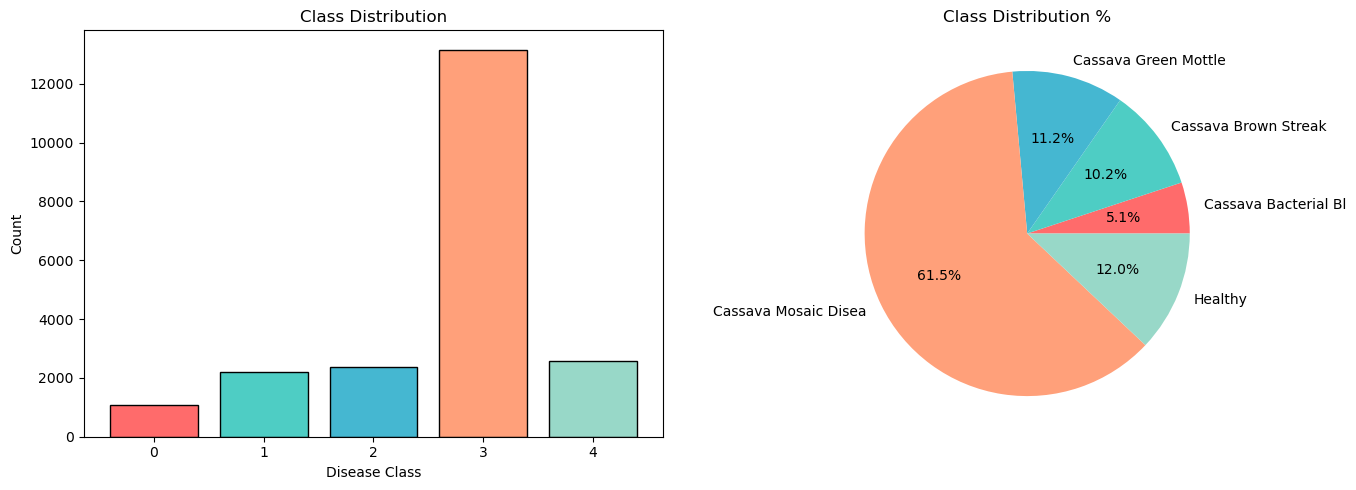


✓ Class distribution visualized


In [17]:
print("\n" + "="*80)
print("SECTION 2: DATA EXPLORATION & VISUALIZATION")
print("="*80)

# Class distribution
class_counts = df['label'].value_counts().sort_index()

print("\nClass Distribution:")
for i in range(cfg.NUM_CLASSES):
    count = class_counts[i]
    pct = count / len(df) * 100
    print(f"  Class {i} ({label_map[str(i)][:30]}...): {count} ({pct:.1f}%)")

# Imbalance ratio
max_count = class_counts.max()
min_count = class_counts.min()
imbalance_ratio = max_count / min_count
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}")
if imbalance_ratio > 2:
    print("  Class imbalance detected - will use class weights!")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

# Bar chart
axes[0].bar(range(cfg.NUM_CLASSES), class_counts.values, color=colors, edgecolor='black')
axes[0].set_xlabel('Disease Class')
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution')
axes[0].set_xticks(range(cfg.NUM_CLASSES))

# Pie chart
axes[1].pie(class_counts.values, labels=[label_map[str(i)][:20] for i in range(cfg.NUM_CLASSES)],
           autopct='%1.1f%%', colors=colors)
axes[1].set_title('Class Distribution %')

plt.tight_layout()
plt.show()  # Display in notebook instead of saving
print("\n✓ Class distribution visualized")

#### Section 3: Data Preparation

In [21]:
print("\n" + "="*80)
print("SECTION 3: DATA PREPARATION")
print("="*80)

# Split data (stratified to maintain class distribution)
train_val_df, test_df = train_test_split(
    df, test_size=cfg.TEST_SPLIT, stratify=df['label'], random_state=cfg.SEED
)

val_size = cfg.VAL_SPLIT / (cfg.TRAIN_SPLIT + cfg.VAL_SPLIT)
train_df, val_df = train_test_split(
    train_val_df, test_size=val_size, stratify=train_val_df['label'], random_state=cfg.SEED
)

print(f"\nDataset Splits:")
print(f"  Training:   {len(train_df):5d} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Validation: {len(val_df):5d} ({len(val_df)/len(df)*100:.1f}%)")
print(f"  Test:       {len(test_df):5d} ({len(test_df)/len(df)*100:.1f}%)")


SECTION 3: DATA PREPARATION

Dataset Splits:
  Training:   14977 (70.0%)
  Validation:  3210 (15.0%)
  Test:        3210 (15.0%)


In [22]:
# Convert labels to strings (required by flow_from_dataframe with categorical mode)
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

# Compute class weights (using original integer labels)
class_weights_array = compute_class_weight(
    'balanced', classes=np.arange(cfg.NUM_CLASSES), 
    y=train_df['label'].astype(int)
)
class_weights = {i: w for i, w in enumerate(class_weights_array)}

print(f"\nClass Weights (for imbalanced data):")
for i, w in class_weights.items():
    print(f"  Class {i}: {w:.4f}")

# Create data generators
print(f"\nCreating data generators...")

# WITHOUT augmentation (baseline)
train_gen_no_aug = ImageDataGenerator(rescale=1./255)

# WITH augmentation
train_gen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=cfg.AUG_ROTATION,
    width_shift_range=cfg.AUG_SHIFT,
    height_shift_range=cfg.AUG_SHIFT,
    zoom_range=cfg.AUG_ZOOM,
    brightness_range=cfg.AUG_BRIGHTNESS,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_gen = ImageDataGenerator(rescale=1./255)

# Create flows
train_flow_no_aug = train_gen_no_aug.flow_from_dataframe(
    train_df, cfg.TRAIN_IMAGES_DIR, x_col='image_id', y_col='label',
    target_size=cfg.IMG_SIZE, batch_size=cfg.BATCH_SIZE,
    class_mode='categorical', shuffle=True, seed=cfg.SEED
)

train_flow_aug = train_gen_aug.flow_from_dataframe(
    train_df, cfg.TRAIN_IMAGES_DIR, x_col='image_id', y_col='label',
    target_size=cfg.IMG_SIZE, batch_size=cfg.BATCH_SIZE,
    class_mode='categorical', shuffle=True, seed=cfg.SEED
)

val_flow = val_test_gen.flow_from_dataframe(
    val_df, cfg.TRAIN_IMAGES_DIR, x_col='image_id', y_col='label',
    target_size=cfg.IMG_SIZE, batch_size=cfg.BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

test_flow = val_test_gen.flow_from_dataframe(
    test_df, cfg.TRAIN_IMAGES_DIR, x_col='image_id', y_col='label',
    target_size=cfg.IMG_SIZE, batch_size=cfg.BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

print("✓ Data generators created")


Class Weights (for imbalanced data):
  Class 0: 3.9361
  Class 1: 1.9539
  Class 2: 1.7937
  Class 3: 0.3252
  Class 4: 1.6613

Creating data generators...
Found 14977 validated image filenames belonging to 5 classes.
Found 14977 validated image filenames belonging to 5 classes.
Found 3210 validated image filenames belonging to 5 classes.
Found 3210 validated image filenames belonging to 5 classes.
✓ Data generators created
